In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from utils import *
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

%matplotlib inline

# Image Classification with Unstructured Environments

1. [Introduction and Motivation](#1.-Introduction-and-Motivation)
2. [General Techniques](#2.-General-Techniques)
3. Building a vocabulary
  1. Obtain training data
  2. Get SIFT feature vectors for all training images
  3. K-means clustering to get term vectors
4. Classifying images
  1. Load some test data, and test it
5. [Improving Feature Detection](#5.-Improving-Feature-Detection)
  2. [Saliency](#a.-Saliency)
  3. [Hue Information](#b.-Hue-Information)
6. Conclusion

## 1. Introduction and Motivation

In this mini problem set, you will how to apply image classification to marine environments. Unlike typical object recognition tasks that recognize objects that have limited variability in form, content, and shape, marine image classification requires a system that can handle incredible variability in object form. Take the following images of sand and seaweed, for example:

<img src="header.png" width="500" height="500"/>

These images include a tangle of objects, variable colors, occlusion, and other issues that make typical object recognition inaccurate. Throughout this mini problem set, you will learn how to build better models and methods for dealing with unstructured environments such as those found in marine habitats. The goal is to create a system with a higher accuracy in recognizing parts of a marine habitat, which would come in handy during AUV surveying and planning.

## 2. General Techniques

Before diving into applying the new techniques learned from lecture, let's explore state-of-the-art general techniques in image recognition. A prime example of this is provided from Google's Vision API. Visit their website at [https://cloud.google.com/vision/](https://cloud.google.com/vision/), and take a look at the services provided. Let's take a look what happens when we attempt to classify two different images.

First, save the image below of a horse to your computer, and upload it to the site above in the section labeled "Try the API". Note the words that it finds that are representative of the objects in that image.

<img src="horse.jpg" width="200" height="200"/>

Now, try doing the same thing with the below image of a seafloor. Once again, note the words that it decides are representative of the objects in the image.

<img src="sandy_image.png" width="200" height="200"/>

Given these results, answer the following questions:

**a) What words does it find for each of these images? What do you notice about the type of words that it finds for each image? Why do you think this is happening?**

**b) Why do you think it would be unfair to compare these two images using Google's system?**
<br/>
<div class="alert alert-info">
Please enter your answer in the following box.
</div>

INSERT ANSWER HERE

# 3. Finding Interest Point Operators

Interest point operators can help us find points or features in the image that are unique and tell us something about the picture as a whole. These features are often found on the edges and corners of the image because these boundary points separate out the foreground, where interesting features are, from the lighter image background. We will be exploring a technique called MSER in this mini problem set to find high contrast regions of the image which represent edges, and sample features from those points.

### a. Thresholding

We will explore the concept of thresholding, which is the idea that a threshold is set between 0 and 255 (the values that a pixel can be) and all the pixels above that number are white and all those below the number are black. In the code below, the function MSER takes in a threshold value. Then the display image (a picture of a horse) is read as a numpy array with dimensions 128x128 with pixel values between 0 and 255. Your task is to fill in the code in the area specified so that pixel values below the threshold are 0, which means they are black and pixel values above the threshold are 255, which means they are white. Your final image should be called 'final' in order to be properly displayed. You can check yourself by ensuring that your pictures at threshold levels 80, 100 and 120 look like the following pictures respectively.

<img src="80" width="200" height="200"/>
<img src="100" width="200" height="200"/>
<img src="120" width="200" height="200"/>

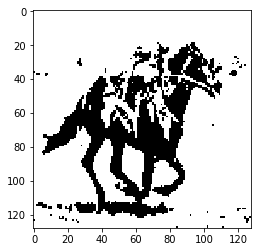

In [3]:
def MSER(threshold):
    '''
    threshold: the pixel value such that all pixels below this value should be black and all pixels above this value 
    should be white
    
    returns the image where the threshold has been applied as a numpy array
    '''
    display_img = cv2.imread('00000019.jpg', 0)
    
    black = np.asarray([[255 for _ in range(128)] for _ in range(128)])
    higher = display_img < threshold
    higher = higher.astype(int)
    final = higher * black
    
    plt.imshow(final, cmap='Greys'),plt.show()
    return final

#You can change the threshold to whatever you want for testing but make sure 
#to change it back to 80 before you move on to the next part
final = MSER(80)

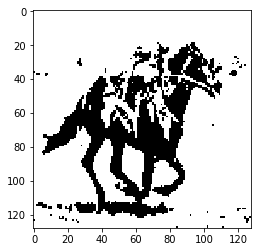

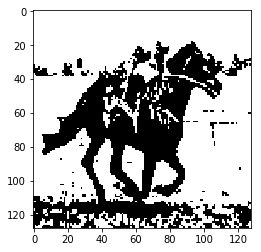

'Tests passed!'

In [5]:
test_MSER(MSER)

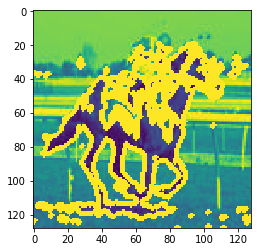

{(119, 34),
 (107, 81),
 (53, 53),
 (57, 50),
 (25, 78),
 (63, 76),
 (61, 82),
 (20, 75),
 (42, 88),
 (49, 58),
 (30, 100),
 (60, 81),
 (45, 78),
 (38, 119),
 (78, 46),
 (48, 77),
 (79, 85),
 (66, 42),
 (122, 63),
 (37, 54),
 (113, 77),
 (44, 104),
 (42, 67),
 (49, 51),
 (123, 20),
 (31, 103),
 (48, 107),
 (116, 125),
 (82, 61),
 (45, 71),
 (121, 110),
 (32, 68),
 (57, 60),
 (117, 26),
 (48, 68),
 (29, 62),
 (33, 59),
 (36, 80),
 (110, 59),
 (41, 43),
 (97, 70),
 (61, 56),
 (27, 72),
 (88, 74),
 (76, 78),
 (45, 47),
 (101, 82),
 (66, 84),
 (70, 57),
 (35, 105),
 (77, 41),
 (102, 51),
 (32, 91),
 (107, 68),
 (46, 33),
 (33, 60),
 (37, 87),
 (51, 71),
 (42, 53),
 (62, 48),
 (119, 33),
 (84, 5),
 (35, 110),
 (77, 34),
 (117, 123),
 (82, 47),
 (63, 19),
 (33, 68),
 (57, 78),
 (58, 68),
 (39, 106),
 (95, 89),
 (43, 111),
 (61, 74),
 (66, 55),
 (51, 76),
 (52, 70),
 (98, 49),
 (55, 72),
 (40, 106),
 (40, 88),
 (99, 50),
 (82, 38),
 (67, 55),
 (50, 63),
 (124, 26),
 (58, 79),
 (43, 100),
 (46

In [13]:
def returnPoints(picture):
    display_x_img = cv2.imread('00000019.jpg', 0)
    points = set()
    for x in range(len(picture)):
        for y in range(1, len(picture[0])):
            if abs(picture[x][y] - picture[x][y-1]) > 254:
                points.add((x, y))

    #add your code here
    for y in range(128):
        for x in range(1, 128):
            if abs(picture[x][y] - picture[x-1][y]) > 254:
                points.add((x, y))

    
    for i in points:
        y,x = i
        cv2.circle(display_x_img,(x,y),1,255,-1)
    
    plt.imshow(display_x_img),plt.show()
    return points



returnPoints(final)

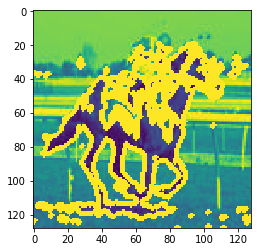

'Tests passed!'

In [14]:
test_returnPoints(returnPoints)

# 3. Traditional Image Classification

We have defined a function for you to use to obtain the training data. This function iterates through every image file in the directory and SIFT runs on each image creating an array of feature vectors for each image. 

In the parent directory we have provided you with 2 folders containing images of auditoriums (labeled "Auditorium") and bowling alleys (labeled "Bowling"). 

The return_labels function takes in 5 inputs: 

* directoryList: list of directory labels
* range_size: the size of the term vector for each image, typically (added_limt * 128) if feature vector is 128
* added_limit: Given that not all images will not have the same number of interest points, we provide a smaller uniform number to consider. 
* count_limit: Desired number of interest points found in a single picture
* patch_size: The size of a patch(size of a feature around an interest point in pixels) defaulted to 32


Run the following cell to obtain the training data. You will find that return_labels does not work for high count_limits because  SIFT will not find enough feature points on an image.

In [20]:
count_limit = 12
range_size =  count_limit*128
sift_pictures = return_labels(['Bowling', 'Auditorium'], range_size, count_limit, 100)
print(sift_pictures)

12
('range: ', 1536)
('count: ', 100)
[[  6.   8.   2. ...  40. 125.  23.]
 [ 14.  15.  44. ...   9.   5.  38.]
 [  3.  18.  76. ...  41.  19.  14.]
 ...
 [  4.   5.   6. ...  10. 115.  78.]
 [  8.   8.   7. ...   1.   1.   2.]
 [ 24.  27.  33. ...  21.  28.  14.]]


Analyze the dimensions of the output array from return_labels while considering the input arguments and explain the format of the output that it provides? You may modify the code in the cell above to print the dimensions you are interested in. 
How would you split the data to process each feature independently?

<div class="alert alert-info">
Please answer in the following cell.
</div>

INSERT ANSWER HERE

Now that you have identified values to run return_labels and SIFT, what is the best values for range_size and count_limit to get the most accurate classification results. Run the following cell to find the clusters using K-Means clustering. 

In [44]:
count_limit = 12
range_size =  count_limit*128
labels_list = ['Bowling', 'Auditorium']
sift_pictures = return_labels(labels_list, range_size, count_limit, 100)
print(len(sift_pictures[0]))
kmeans = KMeans(n_clusters=2, random_state=1).fit(sift_pictures)
print(sift_pictures)
preds = kmeans.predict(sift_pictures)
print(preds)
print(len(preds))
print(kmeans_accuracy(preds, labels_list))


12
('range: ', 1536)
('count: ', 100)
1536
[[  6.   8.   2. ...  40. 125.  23.]
 [ 14.  15.  44. ...   9.   5.  38.]
 [  3.  18.  76. ...  41.  19.  14.]
 ...
 [  4.   5.   6. ...  10. 115.  78.]
 [  8.   8.   7. ...   1.   1.   2.]
 [ 24.  27.  33. ...  21.  28.  14.]]
[0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0
 0 1 0 1 0]
42
0.5


Why do the values you found end up being the best values to run SIFT? How can you increase the accuracy? Comment on the accuracies you see, is this a good image classifier?

<div class="alert alert-info">
Please answer in the following cell.
</div>

INSERT ANSWER HERE

# 4. Bag of Features: Processing Training Data

Above, we performed image classification by considering the entire picture as a single vector, including all of the features. Now we will implement Bag Of Features. 



First we want to get a set of all of the features from all of the pictures to build a vocabulary. 
Implement the function below:

In [26]:
def extract_feature_set(sift_pictures):
    '''
    sift_pictures - data structure studied above that includes all features from all pictures
    
    return set of 128 length features from all pictures
    
    '''
    # separate sift_pictures into individual pictures. 
    # for each picture, separate its descriptor into individual features (remember features are length 128).
    # add the individual features to the output set.
    out = []
    for i in range(len(sift_pictures)):
        curr_pic = sift_pictures[i]
        parts = np.hsplit(curr_pic, 128)
        out.append(parts)
    return np.vstack(out)

Next you will use the feature set to build the vocabulary. HINT: use the K-Means functions from the sklearrn library. You may find it useful to reference the code in section TODO.

In [23]:
def build_vocab(set_of_features, k):
    '''
    set_of_features - set of 128 length sift descriptors
    k - number of terms in our vocabulary
    
    return an sklearn k-means classifier fitted to the feature set
    '''
    # use sklearn to create a k-means classifier that groups input into k clusters
    # fit the classifier to the set of features
    # output the classifier 
    clf = KMeans(n_clusters=k, random_state=1)
    clf.fit(set_of_features)
    return clf

Now you will create a term vector for one of the training images. 

In [32]:
def generate_term_vector(sift_picture, k, vocab_classifier):
    '''
    sift_picture - a single picture represented as a concatenation of all of its features
    k - number of terms in our vocabulary
    vocab_classifier - sklearn k-means classifier of vocab features
    
    return term vector - a list of feature counts from the input picture
    '''
    # intialize the term vector to be a length-k list of 0s, where k is the number of terms in the vocab
    # separate picture into individual features
    # for each feature:
    #     use the kmeans classifier to classify the feature as one of the vocabulary items
    #     increment the appropriate entry in the term vector each time a feature is found
    # return the feature vector
    tv = [0 for i in range(k)]
    features = np.hsplit(sift_picture, 128)
    for feature in features:
        result = vocab_classifier.predict(feature.reshape(1,-1))
        tv[int(result)] += 1
    return tv

Lastly, we will put all of these helper methods together to process the training data. We will give you an outline of how to do this, but feel free to implement it however you please.

In [24]:
def process_training_data(count_limit, k):
    '''
    k - number of terms in our vocabulary
    
    returns (labeled_term_vectors, k, vocab_classifier)
    
            labeled_term_vectors: 
                list of tuples describing labels of known points; 
                   first element of each tuple is the term vector
                   second element of each tuple is the label
                   ex. [([...], 'label1'), ([...],'label2'),...]
            vocab_classifier: sklearn k-means classifier of vocab features
    '''
    range_size = count_limit * 128
    sift_pictures = return_labels(['Bowling', 'Auditorium'], range_size, count_limit, 100)
    
    # extract the feature set from all of the pictures
    # build a vocabulary from the feature set, get a k-means classifier for feature vectors
    features = extract_feature_set(sift_pictures)
    #print(features)
    clf = build_vocab(features, k)
    labeled_term_vectors = []
    # get the sift_pictures for the bowling alleys alone from return_labels
    bowling_pictures = return_labels(['Bowling'], range_size, count_limit, 100)
    # for each picture:
    #     get its term vector
    #     add it to labeled_term_vectors with the label 'Bowling'
    
    for pic in bowling_pictures:
        labeled_term_vectors.append((generate_term_vector(pic, k, clf), 'Bowling'))
    
    # get the sift_pictures for the auditoriums alone from return_labels
    auditorium_pictures = return_labels(['Auditorium'], range_size, count_limit, 100)
    # for each picture:
    #     get its term vector
    #     add it to labeled_term_vectors with the label 'Auditorium'
    for pic in bowling_pictures:
        labeled_term_vectors.append((generate_term_vector(pic, k, clf), 'Auditorium'))
    
    return (labeled_term_vectors, clf)

In [35]:
print(process_training_data(count_limit=12, k=5))

12
('range: ', 1536)
('count: ', 100)
12
('range: ', 1536)
('count: ', 100)
12
('range: ', 1536)
('count: ', 100)
([([16, 64, 14, 12, 22], 'Bowling'), ([24, 51, 18, 11, 24], 'Bowling'), ([29, 35, 19, 14, 31], 'Bowling'), ([28, 40, 17, 14, 29], 'Bowling'), ([21, 57, 10, 17, 23], 'Bowling'), ([22, 62, 22, 9, 13], 'Bowling'), ([34, 37, 14, 12, 31], 'Bowling'), ([19, 68, 15, 9, 17], 'Bowling'), ([38, 23, 18, 15, 34], 'Bowling'), ([27, 41, 20, 12, 28], 'Bowling'), ([26, 38, 21, 12, 31], 'Bowling'), ([28, 44, 18, 16, 22], 'Bowling'), ([21, 49, 20, 10, 28], 'Bowling'), ([36, 43, 18, 10, 21], 'Bowling'), ([35, 32, 20, 11, 30], 'Bowling'), ([19, 54, 17, 12, 26], 'Bowling'), ([24, 54, 16, 13, 21], 'Bowling'), ([35, 34, 14, 12, 33], 'Bowling'), ([27, 47, 18, 12, 24], 'Bowling'), ([26, 40, 19, 16, 27], 'Bowling'), ([26, 54, 22, 8, 18], 'Bowling'), ([15, 65, 14, 11, 23], 'Bowling'), ([28, 44, 15, 18, 23], 'Bowling'), ([26, 41, 11, 20, 30], 'Bowling'), ([16, 64, 14, 12, 22], 'Auditorium'), ([24, 51,

In [74]:
test_process_training_data(process_training_data)
test_ok()

12
('range: ', 1536)
('count: ', 100)
12
('range: ', 1536)
('count: ', 100)
12
('range: ', 1536)
('count: ', 100)


Tests passed!!

# 5. Bag of Features: Classifying New Images

Having processed the training images, building a vocabulary and getting term vectors, we now want to be able to classify an unknown image. We can use the same functions as we developed in the previous section to convert a new image to a term vector, but then we need to figure out the classification of the new term vector.

To do this, we will use the k-nearest-neighbors (KNN) algorithm. Given a set of labeled data (in this case term vectors corresponding to images) as "examples", the algorithm will classify a new datum based on the $k$ examples to which the unobserved datum is "nearest".

There are many ways to define distance between one example and another, but one of the most straightforward and common approaches is to use Euclidean distance (or "L2-norm" if you want to be fancy).

For this next part of the assignment, implement the KNN algorithm in the space provided. Then you will use this to classify some unknown images.

In [56]:
def get_k_closest(point, known_points, k):
    '''
    point - unknown point (Numpy array of term vector)
    
    known_points - list of tuples describing labels of known points; 
                   first element of each tuple is the sift feature vector
                   second element of each tuple is the corresponding label
                   ex. [([...], 'label1'), ([...],'label2'),...]
                   
    k - an integer (corresponding to the number of neighbors to consider)
    
    Returns: the k tuples from known_points corresponding to the k closest points
             to the unknown point (as a list)
    '''
    distances = np.zeros(len(known_points))
    for i in range(len(known_points)):
        dist = np.linalg.norm(np.array(point) - np.array(known_points[i][0]))
        distances[i] = dist
    indices = np.argsort(distances)[:k]
    #print(np.sort(distances)[:k])
    results = []
    for i in range(len(indices)):
        results.append(known_points[indices[i]])
    #print(results)
    return results

In [60]:
def knn(known_points, unknown_points, k):
    '''
    known_points - list of tuples describing labels of known points; 
                   first element of each tuple is the sift feature vector
                   second element of each tuple is the corresponding label
                   ex. [([...], 'label1'), ([...],'label2'),...]
                   
    unknown_points - list of term vectors (Numpy arrays) corresponding to 
                    examples needing classification
                    
    k - an integer (corresponding to the number of neighbors to consider)
    
    Returns: list of tuples describing the assigned labels of previously unknown points
             (in the same order as the input)
    '''
    results = []
    for i in range(len(unknown_points)):
        neighbors = get_k_closest(unknown_points[i], known_points, k)
        #print(neighbors)
        freqs = {}
        for neighbor in neighbors:
            label = neighbor[1]
            if label not in freqs:
                freqs[label] = 0
            freqs[label] += 1
        
        max_label = -1
        max_amt = -1
        for label in freqs:
            if freqs[label] > max_amt:
                max_amt = freqs[label]
                max_label = label
        results.append((unknown_points[i], max_label))
    return results

In [73]:
test_process_training_data(process_training_data)
test_ok()

12
('range: ', 1536)
('count: ', 100)
12
('range: ', 1536)
('count: ', 100)
12
('range: ', 1536)
('count: ', 100)


Tests passed!!

Now answer the following questions about your KNN implementation in the cell below.

1. Why don't we want to use even numbers as values of $k$?
2. How would you go about finding the best value of $k$?
3. What was the best value of $k$ that worked for the data given above? (TODO: figure out data to give)

<div class="alert alert-info">
Please enter your answer in the following box.
</div>

Now we will use this implementation to classify new images.

In [58]:
def classify_new_images(k, count_limit):
    '''
    k: parameter defining the number of terms in the vocabulary
    
    return list of tuples describing the assigned labels of previously unknown images from the "unknown" directory
    '''
    range_size =  count_limit*128
    known_pictures = return_labels(['Bowling', 'Auditorium'], range_size, count_limit, 100)
    unknown_pictures = return_labels(['Unknown'], range_size, count_limit, 100)
    
    # process the training pictures to get a labeled list of term vectors and a vocab classifier
    #    (use the function you implemented in 4)
    
    # create a list of term vectors of the unknown images:
    # for each of the pictures in the unknown picture directory:
    #     generate a term vector
    #     add the term vector to the list of term vectors
    
    # use your knn implementation to label the list of unknown term vectors
    
    # return the labeled images
    labeled_term_vectors, clf = process_training_data(count_limit, k)
    #print(labeled_term_vectors)
    unknown_term_vectors = []
    for pic in unknown_pictures:
        vec = generate_term_vector(pic, k, clf)
        unknown_term_vectors.append(vec)
    return knn(labeled_term_vectors, unknown_term_vectors, k)

In [72]:
test_knn(classify_new_images)
test_ok()

10
('range: ', 1280)
('count: ', 100)
10
('range: ', 1280)
('count: ', 100)
10
('range: ', 1280)
('count: ', 100)
10
('range: ', 1280)
('count: ', 100)
10
('range: ', 1280)
('count: ', 100)


Tests passed!!

Now you can test your bag of features implementation in the tester below. You can change the parameters k and count_limit to maximize your accuracy.

In [67]:
k = 10
count_limit = 10

labeled_images = classify_new_images(k, count_limit)
print(labeled_images)
print "Accuracy: ",  str(check_bof_accuracy(labeled_images))

10
('range: ', 1280)
('count: ', 100)
10
('range: ', 1280)
('count: ', 100)
10
('range: ', 1280)
('count: ', 100)
10
('range: ', 1280)
('count: ', 100)
10
('range: ', 1280)
('count: ', 100)
[([13, 46, 9, 4, 8, 11, 11, 5, 12, 9], 'Auditorium'), ([9, 39, 7, 3, 12, 18, 17, 4, 9, 10], 'Bowling'), ([18, 35, 8, 9, 10, 14, 13, 3, 11, 7], 'Bowling'), ([10, 50, 8, 5, 7, 8, 13, 8, 13, 6], 'Auditorium'), ([14, 35, 14, 0, 13, 13, 11, 6, 15, 7], 'Bowling'), ([15, 32, 9, 5, 14, 13, 13, 6, 19, 2], 'Bowling'), ([15, 33, 10, 6, 14, 14, 12, 4, 16, 4], 'Bowling'), ([5, 40, 15, 6, 8, 14, 19, 8, 10, 3], 'Bowling'), ([17, 28, 17, 7, 7, 10, 19, 4, 18, 1], 'Bowling'), ([15, 52, 4, 3, 11, 10, 4, 8, 13, 8], 'Auditorium')]
Accuracy:  [[[9, 39, 7, 3, 12, 18, 17, 4, 9, 10] 'Bowling']
 [[9, 39, 7, 3, 12, 18, 17, 4, 9, 10] 'Bowling']
 [[9, 39, 7, 3, 12, 18, 17, 4, 9, 10] 'Bowling']
 [[9, 39, 7, 3, 12, 18, 17, 4, 9, 10] 'Bowling']
 [[9, 39, 7, 3, 12, 18, 17, 4, 9, 10] 'Bowling']
 [[9, 39, 7, 3, 12, 18, 17, 4, 9, 10] 

# 6. Improving Feature Detection

Now that we have gone through the process of obtaining feature vectors for our training images and classifying test images against this data, we can begin to make adjustments for handling unstructured environments. As covered in the lecture, two useful extensions are the use of saliency and hue information.

### a. Saliency
Recall from the lecture that saliency is a measure of entropy used to determine how "interesting" a patch is. We can use this to select regions of images that are better for training. Recall that the entropy for a discrete random variable is given by

$$E(\Delta I)=H=-\sum_{i=1}^{n}p(x_{i})\log p(x_{i})$$

For the gray scale image we define the probability $p(x)$ as follows,

$$p(x_{i})={h(x_{i\over N})={1\over N}\sum_{j=1}^{N}\delta(x_{i}-x_{j})}$$

where $\delta$ is the discrete Dirac delta function:
$$\delta(x)=\cases{1, x=0\cr 0, x\neq 0 } $$

So finally the entropy of a patch with $N_p$ pixels will be:
$$H_{g}=-{1\over N_{p}}\sum_{j=1}^{N_{p}}\log p_{g}(x_{j}) $$
It is important to note that we are calculating the log probability, $p_{g}$ using all the pixels in the image, but the outermost sum is just over the pixels in the patch.

Implement the function below which returns the total entropy for a given patch. The parameter `log_probs` is a list of values which represents the log probability of each pixel based off the global distribution of pixels.

<div class="alert alert-info">
Implement the method below.
</div>

In [18]:
def get_patch_entropy(log_probs):
    '''
    log_probs - list of values which represents the log probability of each pixel
    '''
    
    # YOUR CODE HERE
    raise NotImplementedError

In [19]:
def test_get_patch_entropy():
    test_patch_entropy_solution(get_patch_entropy)
    test_ok()
test_get_patch_entropy()

NotImplementedError: 

### b. Hue Information
As explained in the introduction, color is an important feature in correctly classifying unstructured environments such as coral. In order to incorporate this data into our training / features, we add the average hue of the patch to the feature vectors that are created using SIFT. The hue value can be visualized below, and is found by convering a pixel in RGB into the HSV color space.

<img src="hue.png" width="200" height="200"/>

If we have a 128-dimension feature vector from SIFT representing a patch, then the new feature vector would be of dimension 129. However, a trick/hack that we can employ is to copy the hue value into the feature vector multiple times. By adding, say, 10 more features which each hold the hue data, we may be able to achieve higher classification accuracies.

The graph below shows the change in classification accuracy as we change the number of times the hue feature has been added to the patch feature vector. The classification accuracy was found by classifying seaweed against sand.

<img src="hue_graph.png" width="500" height="500"/>

Given these results, answer the following questions:

**a) What do you notice about the effect of hue data on classifiction accuracy? Do you notice anything strange, or anything that was expected?**

**b) Why do you think that hue was a good feature to include, especially with these data sets?**

<div class="alert alert-info">
Please enter your answer in the following box.
</div>

PUT ANSWER HERE

## Done!

Congratulations, you've completed this problem set! Please save this notebook, validate it, and submit it.